In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display
import tensorflow as tf

In [0]:
np.random.seed(101)
tf.set_random_seed(101)

## Dataset
** Alternative sources of the data just in case: **

* http://yann.lecun.com/exdb/mnist/
* https://github.com/mrgloom/MNIST-dataset-in-different-formats

In [3]:
from keras.datasets import mnist

(X, y), (X_test, y_test) = mnist.load_data('/tmp/mnist.npz')

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print('')
print(X_val.shape)
print(y_val.shape)
print('')
print(X_test.shape)
print(y_test.shape)

Using TensorFlow backend.


(48000, 28, 28)
(48000,)

(12000, 28, 28)
(12000,)

(10000, 28, 28)
(10000,)


In [4]:
# not normalized
print(X_train[0].max())
print(X_train[0].min())

255
0


5


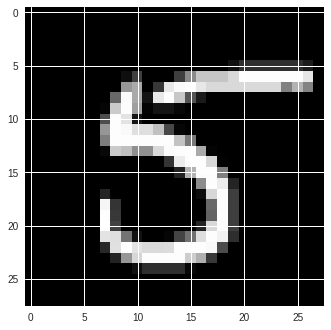

In [5]:
plt.imshow(X_train[0], cmap='gray');
print(y_train[0])

## Feature Engineering

In [6]:
# Unroll X
X_train_rs = X_train.reshape(-1, 28*28)
X_val_rs = X_val.reshape(-1, 28*28)
X_test_rs = X_test.reshape(-1, 28*28)

# Normalize X [0 - 1]
X_train_norm = X_train_rs.astype('float32') / 255.0
X_val_norm = X_val_rs.astype('float32') / 255.0
X_test_norm = X_test_rs.astype('float32') / 255.0

print(X_train_norm.shape)
print(X_val_norm.shape)
print(X_test_norm.shape)

(48000, 784)
(12000, 784)
(10000, 784)


In [7]:
# One hot encoding y
from keras.utils.np_utils import to_categorical

y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

print(y_train_cat.shape)
print(y_val_cat.shape)
print(y_test_cat.shape)

(48000, 10)
(12000, 10)
(10000, 10)


## Model
```python
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))
```

In [0]:
tf.reset_default_graph()

In [9]:
input_nerons = 28*28
layer_1_nerons = 512
layer_2_nerons = 256
output_neurons = 10

# Placeholders
X_ph = tf.placeholder(tf.float32, shape=[None,input_nerons])
y_ph = tf.placeholder(tf.float32, shape=[None,output_neurons])

# Init var
W1_init = np.random.randn(input_nerons, layer_1_nerons) / 28
b1_init = np.zeros(layer_1_nerons)

W2_init = np.random.randn(layer_1_nerons, layer_2_nerons) / 28
b2_init = np.zeros(layer_2_nerons)

W3_init = np.random.randn(layer_2_nerons, output_neurons) / 28
b3_init = np.zeros(output_neurons)

# Variables
W1 = tf.Variable(W1_init.astype(np.float32))
b1 = tf.Variable(b1_init.astype(np.float32))

W2 = tf.Variable(W2_init.astype(np.float32))
b2 = tf.Variable(b2_init.astype(np.float32))

W3 = tf.Variable(W3_init.astype(np.float32))
b3 = tf.Variable(b3_init.astype(np.float32))

# Graph
Z1 = tf.nn.relu(tf.matmul(X_ph, W1) + b1)
Z2 = tf.nn.relu(tf.matmul(Z1, W2) + b2)
y_pred = tf.matmul(Z2, W3) + b3

# Loss function
loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(
        labels=y_ph,
        logits=y_pred))

# Optimizer
optimizer = tf.train.RMSPropOptimizer(
    learning_rate=0.00004,
    decay=0.99,
    momentum=0.9)

# Trainning function
train = optimizer.minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [0]:
def next_batch(X, y, batch_size=10):
    # Select a random batch index
    rand_idx = np.random.randint(
        len(X),
        size=batch_size)

    return X[rand_idx], y[rand_idx]

In [11]:
# Init Variables
init = tf.global_variables_initializer()

# GPU option
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

# Saver
saver = tf.train.Saver()

# Epochs
epochs = 4001

# Accuracies
train_accs = []
val_accs = []

# Losses
train_losses = []
val_losses = []

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    # Init Variables
    sess.run(init)
    
    # Run epochs
    for i in range(epochs):
        # Select a random batch
        X_batch , y_batch = next_batch(
            X_train_norm , y_train_cat,
            batch_size=100)

        # Train
        sess.run(
            train,
            feed_dict={
                X_ph: X_batch,
                y_ph: y_batch})
        
        if i%100 == 0:
            # Train acc
            train_matches = tf.equal(
                tf.argmax(y_batch, 1),
                tf.argmax(y_pred, 1))

            train_accuracy = tf.reduce_mean(tf.cast(train_matches,tf.float32))

            train_acc = sess.run(
                train_accuracy,
                feed_dict={
                    X_ph: X_batch,
                    y_ph: y_batch})

            train_accs.append(train_acc)
            
            # Train loss
            train_loss = loss.eval(
                feed_dict={
                    X_ph: X_batch,
                    y_ph: y_batch})
            train_losses.append(train_loss)
            
            # Val acc
            val_matches = tf.equal(
                tf.argmax(y_val_cat, 1),
                tf.argmax(y_pred, 1))

            val_accuracy = tf.reduce_mean(tf.cast(val_matches,tf.float32))

            val_acc = sess.run(
                val_accuracy,
                feed_dict={
                    X_ph: X_val_norm,
                    y_ph: y_val_cat})

            val_accs.append(val_acc)
            
            # Val loss
            val_loss = loss.eval(
                feed_dict={
                    X_ph: X_val_norm,
                    y_ph: y_val_cat})
            val_losses.append(val_loss)

            # PRINT OUT A MESSAGE EVERY 500 STEPS
            if i%500 == 0:
                print('Epoch {}'.format(i))
                print('train_acc = {} - val_acc = {}'.format(train_acc, val_acc))
                print('train_loss = {} - val_loss = {}\n'.format(train_loss, val_loss))

    # SAVE MODEL
    saver.save(sess, 'my_model/MNIST_DNN.ckpt')

Epoch 0
train_acc = 0.1599999964237213 - val_acc = 0.0741666629910469
train_loss = 2.298356056213379 - val_loss = 2.3063206672668457

Epoch 500
train_acc = 0.4699999988079071 - val_acc = 0.40408334136009216
train_loss = 2.2115747928619385 - val_loss = 2.2239227294921875

Epoch 1000
train_acc = 0.800000011920929 - val_acc = 0.8557500243186951
train_loss = 0.6741442084312439 - val_loss = 0.538291335105896

Epoch 1500
train_acc = 0.9300000071525574 - val_acc = 0.9350833296775818
train_loss = 0.17992396652698517 - val_loss = 0.22874779999256134

Epoch 2000
train_acc = 0.9900000095367432 - val_acc = 0.9645000100135803
train_loss = 0.07368948310613632 - val_loss = 0.12440718710422516

Epoch 2500
train_acc = 1.0 - val_acc = 0.9696666598320007
train_loss = 0.018253518268465996 - val_loss = 0.10300403833389282

Epoch 3000
train_acc = 0.9800000190734863 - val_acc = 0.9725000262260437
train_loss = 0.0777340978384018 - val_loss = 0.08806739002466202

Epoch 3500
train_acc = 1.0 - val_acc = 0.977750

Text(0.5,0,'Epochs')

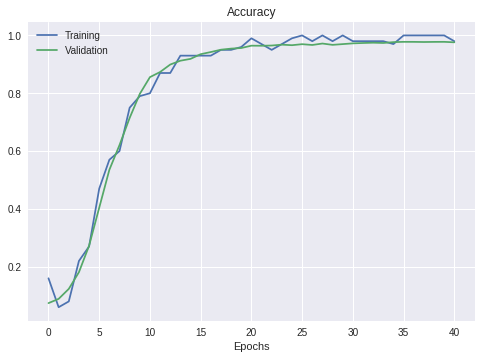

In [12]:
plt.plot(train_accs)
plt.plot(val_accs)

plt.legend(['Training', 'Validation'])
plt.title('Accuracy')
plt.xlabel('Epochs')

Text(0.5,0,'Epochs')

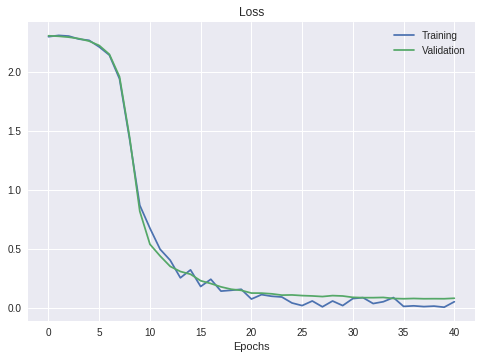

In [13]:
plt.plot(train_losses)
plt.plot(val_losses)

plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epochs')

## Evaluate Test

In [14]:
with tf.Session() as sess:
    # Restore the model
    saver.restore(sess,'my_model/MNIST_DNN.ckpt')
    
    # Test accuracy
    test_matches = tf.equal(
        tf.argmax(y_test_cat, 1),
        tf.argmax(y_pred, 1))

    test_accuracy = tf.reduce_mean(tf.cast(test_matches,tf.float32))

    test_acc = sess.run(
        test_accuracy,
        feed_dict={
            X_ph: X_test_norm,
            y_ph: y_test_cat})

    print('Test set accuracy: ', test_acc)

INFO:tensorflow:Restoring parameters from my_model/MNIST_DNN.ckpt
Test set accuracy:  0.9752
